## Modeling - Citation Prediction

In [1]:
# basic
import sys
import os
import json
import pdb
import ast
import time
import requests
from tqdm import tqdm
from collections import Counter, defaultdict, namedtuple

# debug
import pdb
from loguru import logger

import numpy as np
import pandas as pd

# plotting
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics

# regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost
from xgboost.sklearn import XGBRegressor

# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# from warnings import filterwarnings
# filterwarnings(action='ignore', category=DeprecationWarning,  message='`np.bool` is a deprecated alias')
# filterwarnings(action='ignore', category=DeprecationWarning,  message='`np.int` is a deprecated alias' )
# filterwarnings(action='ignore', category=DeprecationWarning,  message='`np.object` is a deprecated alias')


# custom
from utils import *

SEED = 0

/Users/gautamchoudhary/miniconda3/envs/myenv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gautamchoudhary/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load Data

In [2]:
%%time
YEAR = 2017

works = pd.read_pickle(f'./data/{YEAR}/works.{YEAR}.v2.pkl').set_index('id')
authors = pd.read_pickle(f'./data/{YEAR}/authors.{YEAR}.v2.pkl').set_index('id')
venues = pd.read_pickle(f'./data/{YEAR}/venues.{YEAR}.v2.pkl').set_index('id')
insts = pd.read_pickle(f'./data/{YEAR}/insts.{YEAR}.v2.pkl').set_index('id')

CPU times: user 3.94 s, sys: 299 ms, total: 4.24 s
Wall time: 4.27 s


In [3]:
%%time
works = preprocess_works(works, YEAR, 2022)
authors = preprocess_authors(authors)
venues = preprocess_venues(venues)
insts = preprocess_insts(insts)

CPU times: user 650 ms, sys: 38 ms, total: 688 ms
Wall time: 688 ms


In [4]:
print (f'works \n - shape={works.shape} \n - columns={works.columns.tolist()} \n\n')
print (f'authors \n - shape={authors.shape} \n - columns={authors.columns.tolist()} \n\n')
print (f'venues \n - shape={venues.shape} \n - columns={venues.columns.tolist()} \n\n')
print (f'insts \n - shape={insts.shape} \n - columns={insts.columns.tolist()} \n\n')

works 
 - shape=(145531, 14) 
 - columns=['doi', 'title', 'type', 'publication_date', 'host_venue', 'open_access_is_oa', 'open_access_oa_status', 'authorships', 'page_count', 'cited_by_count', 'concepts', 'referenced_works', 'abstract', 'counts_by_year'] 


authors 
 - shape=(344470, 7) 
 - columns=['orchid', 'display_name', 'works_count', 'cited_by_count', 'created_date', 'concepts', 'counts_by_year'] 


venues 
 - shape=(1854, 8) 
 - columns=['display_name', 'works_count', 'cited_by_count', 'is_oa', 'type', 'created_date', 'concepts', 'counts_by_year'] 


insts 
 - shape=(13227, 10) 
 - columns=['display_name', 'country_code', 'type', 'homepage_url', 'works_count', 'cited_by_count', 'associated_institutions', 'concepts', 'counts_by_year', 'created_date'] 




In [5]:
# works
print (works.shape)
works.head()

(145531, 14)


,doi,title,type,publication_date,host_venue,open_access_is_oa,open_access_oa_status,authorships,page_count,cited_by_count,concepts,referenced_works,abstract,counts_by_year
id,,,,,,,,,,,,,,
W2555618208,https://doi.org/10.1109/cvpr.2017.691,Multi-view 3D Object Detection Network for Aut...,proceedings-article,2017-07-21,V4306417987,True,green,"[[A2119051707, [I99065089]], [A2151001937, [I9...",-1,1409,"[[C131979681, 0.86888766], [C41008148, 0.77201...","[W7746136, W1536680647, W1914646313, W19466097...",This paper aims at high-accuracy 3D object det...,"[(2017, 13), (2018, 109), (2019, 308), (2020, ..."
W2557641257,https://doi.org/10.1109/cvpr.2017.733,ECO: Efficient Convolution Operators for Tracking,proceedings-article,2017-07-21,V4306417987,True,green,"[[A260882311, [I102134673]], [A2557978175, [I1...",-1,1322,"[[C63479239, 0.8030945], [C68339613, 0.7788200...","[W1857884451, W1892578678, W1904671147, W19157...","In recent years, Discriminative Correlation Fi...","[(2017, 9), (2018, 133), (2019, 303), (2020, 3..."
W2963709863,https://doi.org/10.1109/cvpr.2017.241,Learning from Simulated and Unsupervised Image...,proceedings-article,2017-07-21,V4306417987,True,green,"[[A2183241032, [I1311269955]], [A2798413642, [...",-1,1277,"[[C41008148, 0.8212265], [C2779803651, 0.78661...","[W1922126009, W1950149599, W1995694455, W20012...","With recent progress in graphics, it has becom...","[(2017, 55), (2018, 251), (2019, 356), (2020, ..."
W2594519801,https://doi.org/10.1109/cvpr.2017.261,ScanNet: Richly-Annotated 3D Reconstructions o...,proceedings-article,2017-07-21,V4306417987,True,green,"[[A2158018495, [I97018004]], [A2111957820, [I2...",-1,1116,"[[C41008148, 0.8516614], [C82990744, 0.6491697...","[W218762409, W1509835260, W1565402342, W159436...",A key requirement for leveraging supervised de...,"[(2017, 12), (2018, 76), (2019, 226), (2020, 3..."
W2561715562,https://doi.org/10.1109/cvpr.2017.215,CLEVR: A Diagnostic Dataset for Compositional ...,proceedings-article,2017-07-01,V4306417987,True,green,"[[A2345205178, [I97018004]], [A1988254826, [I2...",-1,1085,"[[C41008148, 0.7745689], [C130440534, 0.751482...","[W1933349210, W1983927101, W1996418862, W20646...",When building artificial intelligence systems ...,"[(2017, 38), (2018, 146), (2019, 232), (2020, ..."


In [6]:
# works['page_count'].unique()
# # TODO: error
# works[works['page_count']=='(10,)']

### Feature Extraction

In [7]:
def bin_citations(cc):
    if cc < 6:
        return 0
    else:
        return 1

def count_prior_citations(counts_by_year, YEAR):
    '''
    `counts_by_year` is a list of tuple (year, #works, #citations)
    '''
    counts = [i[2] for i in counts_by_year if i[0]<YEAR]
    if len(counts):
        return np.sum(counts)
    return 0

def count_prior_works(counts_by_year, YEAR):
    '''
    `counts_by_year` is a list of tuple (year, #works, #citations)
    '''
    counts = [i[1] for i in counts_by_year if i[0]<YEAR]
    if len(counts):
        return np.sum(counts)
    return 0


def get_features(works, authors, venues, insts, YEAR):
    '''
    Feature generate given the data for both regression and classification
    '''
    df = pd.DataFrame()

    # `WORK`: Paper meta-data features
    df['no_of_authors'] = works['authorships'].map(lambda x: len(x))
    df['no_of_referenced_works'] = works['referenced_works'].map(len)
    df['open_access_is_oa'] = works['open_access_is_oa']
    df['publication_month'] = works['publication_date'].map(lambda x: int(x.split('-')[1]))

    
    # `AUTHOR`: Author-specific Features
    authors['prior_citations'] = authors['counts_by_year'].map(lambda x: count_prior_citations(x, YEAR))
    a_prior_citations_dict = defaultdict(lambda: 0, authors['prior_citations'].to_dict())
    threshold = authors['prior_citations'].mean()
    df['author_prominency'] = works['authorships'].map(
        lambda x: 1 if max([a_prior_citations_dict[i[0]] for i in x]) >= threshold else 0)
    df['authors_mean_citations'] = works['authorships'].map(lambda x: np.mean([a_prior_citations_dict[i[0]] for i in x]))
    
    authors['prior_works'] = authors['counts_by_year'].map(lambda x: count_prior_works(x, YEAR))
    a_prior_works_dict = defaultdict(lambda: 0, authors['prior_works'].to_dict())
    df['authors_mean_works'] = works['authorships'].map(lambda x: np.mean([a_prior_works_dict[i[0]] for i in x]))

    
    # `VENUE`: Journal and Publisher relevant features
    venues['prior_citations'] = venues['counts_by_year'].map(lambda x: count_prior_citations(x, YEAR))
    v_prior_citations_dict = defaultdict(lambda: 0, venues['prior_citations'].to_dict())
    df['venue_citations'] = works['host_venue'].map(lambda x: v_prior_citations_dict[x])
    
    venues['prior_works'] = venues['counts_by_year'].map(lambda x: count_prior_works(x, YEAR))
    v_prior_works_dict = defaultdict(lambda: 0, venues['prior_works'].to_dict())
    df['venue_works'] = works['host_venue'].map(lambda x: v_prior_works_dict[x])
    
    df['venue_significance'] = works['host_venue'].map(
        lambda x: v_prior_citations_dict[x]/v_prior_works_dict[x] if v_prior_works_dict[x] else 0)
    

    # `INSTITUTION`: Insti-specific Features
    insts['prior_citations'] = insts['counts_by_year'].map(lambda x: count_prior_citations(x, YEAR))
    i_prior_citations_dict = defaultdict(lambda: 0, insts['prior_citations'].to_dict())
    df['insts_mean_citations'] = works['authorships'].map(
        lambda x: np.mean([i_prior_citations_dict[i[1][0]] for i in x if len(i[1])>0]))
    
    insts['prior_works'] = insts['counts_by_year'].map(lambda x: count_prior_works(x, YEAR))
    i_prior_works_dict = defaultdict(lambda: 0, insts['works_count'].to_dict())
    df['insts_mean_works'] = works['authorships'].map(lambda x: np.mean([i_prior_works_dict[i[1][0]] for i in x if len(i[1])>0]))    
    
    # TODO: needs to be corrected
    df.fillna(0, inplace=True)
    
    # target variable - regression
    ## cumulative citation count
    df['y_reg'] = works['counts_by_year'].map(lambda x: np.sum([v for k, v in x if k in [2017, 2018, 2019]]))
    
    # target variable - classification
    df['y_clf'] = df['y_reg'].map(bin_citations)
    
    return df

df = get_features(works, authors, venues, insts, YEAR)

/Users/gautamchoudhary/miniconda3/envs/myenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/gautamchoudhary/miniconda3/envs/myenv/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/gautamchoudhary/miniconda3/envs/myenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/gautamchoudhary/miniconda3/envs/myenv/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Regression

In [8]:
X = df.drop(columns=['y_reg', 'y_clf'])
y = df['y_reg']

In [9]:
# train - test split
TEST_SIZE = 0.2
train_index, test_index = train_test_split(range(len(X)), test_size=TEST_SIZE, random_state=SEED)

X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [10]:
# normalize
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [11]:
# regression analysis

reg_models = {
    'Linear Regression': LinearRegression(n_jobs=-1),
    # 'GradientBoostingRegressor': GradientBoostingRegressor(random_state=SEED),
    # 'SGDRegressor': SGDRegressor(random_state=SEED),
    # 'XGBRegressor': XGBRegressor(random_state=SEED),
    # 'MLPRegressor': MLPRegressor(random_state=SEED, max_iter=100),
}

def eval_regression(model, X_train, X_test, y_train, y_test):
    # model eval
    y_pred = model.predict(X_train)
    rmse = metrics.mean_squared_error(y_true=y_train, y_pred=y_pred, squared=False)
    print (f"  - Train RMSE: {rmse}")
    mae = metrics.mean_absolute_error(y_true=y_train, y_pred=y_pred)
    print (f"  - Train MAE: {mae}")
    r2 = metrics.r2_score(y_true=y_train, y_pred=y_pred)
    print (f"  - Train R^2: {r2}")
    
    y_pred = model.predict(X_test)
    rmse = metrics.mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False)
    print (f"  - Test RMSE: {rmse}")
    mae = metrics.mean_absolute_error(y_true=y_test, y_pred=y_pred)
    print (f"  - Test MAE: {mae}")
    r2 = metrics.r2_score(y_true=y_test, y_pred=y_pred)
    print (f"  - Test R^2: {r2}")
    
    return
    
for model_name, model in reg_models.items():
    # model train
    model.fit(scaler.transform(X_train), y_train)

    print (f"{model_name}:")
    eval_regression(model, scaler.transform(X_train), scaler.transform(X_test),
                   y_train, y_test)

Linear Regression:
  - Train RMSE: 7.676906582425747
  - Train MAE: 2.745838084535733
  - Train R^2: 0.11650603964941919
  - Test RMSE: 7.309125571801371
  - Test MAE: 2.7594734057701844
  - Test R^2: 0.12881337033694706


Feature: 0  Score: ('venue_citations', 1.4619018640172763)
Feature: 1  Score: ('open_access_is_oa', 0.9972549615055074)
Feature: 2  Score: ('authors_mean_citations', 0.962540603384268)
Feature: 3  Score: ('no_of_referenced_works', 0.9476721437150919)
Feature: 4  Score: ('insts_mean_citations', 0.7857731745165819)
Feature: 5  Score: ('venue_significance', 0.3934340475239382)
Feature: 6  Score: ('no_of_authors', 0.32118874083549304)
Feature: 7  Score: ('author_prominency', 0.22681841419924842)
Feature: 8  Score: ('venue_works', -0.11083092255488554)
Feature: 9  Score: ('publication_month', -0.12675038384005696)
Feature: 10  Score: ('insts_mean_works', -0.3593817229398182)
Feature: 11  Score: ('authors_mean_works', -0.7150157475355481)


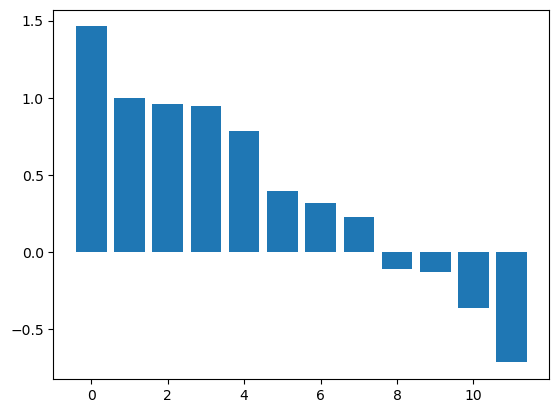

In [12]:
# get importance for linear regression
importance = model.coef_
indices = np.argsort(importance)[::-1]
for i,v in enumerate(zip(X.columns[indices], importance[indices])):
    print('Feature: {}  Score: {}' .format(i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance[indices])
plt.show()

### Classification

In [13]:
X = df.drop(columns=['y_reg', 'y_clf'])
y = df['y_clf']

In [14]:
y.value_counts(normalize=True)

0    0.898833
1    0.101167
Name: y_clf, dtype: float64

In [15]:
# train - test split
TEST_SIZE = 0.2
train_index, test_index = train_test_split(range(len(X)), test_size=TEST_SIZE, random_state=SEED)

X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [16]:
# normalize
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [17]:
# classification analysis

clf_models = {
    'LogisticRegression': LogisticRegression(random_state=SEED, n_jobs=-1),
    # 'XGBoost': xgboost.XGBClassifier(random_state=SEED),
    # 'KNeighborsClassifier': KNeighborsClassifier(n_jobs=-1),
    # 'GaussianNB': GaussianNB(),
    # 'DecisionTreeClassifier': DecisionTreeClassifier(random_state=SEED),
    # 'SVC': SVC(random_state=SEED, max_iter=100, probability=True),
    # 'MLPClassifier': MLPClassifier(random_state=SEED, max_iter=100),
}

def eval_classification(model, X_train, X_test, y_train, y_test):
    # model eval
    y_pred = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_train)[:, 1]
    acc = metrics.accuracy_score(y_true=y_train, y_pred=y_pred)
    print (f'  - Train Accuracy (in %): {acc}')
    f1 = metrics.f1_score(y_true=y_train, y_pred=y_pred, average='weighted')
    print (f'  - Train F1: {f1}')
    auc = metrics.roc_auc_score(y_true=y_train, y_score=y_pred_proba, average='weighted')
    print (f'  - Train AUC: {auc}')
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    acc = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    print (f'  - Test Accuracy (in %): {acc}')
    f1 = metrics.f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    print (f'  - Test F1: {f1}')
    auc = metrics.roc_auc_score(y_true=y_test, y_score=y_pred_proba, average='weighted')
    print (f'  - Test AUC: {auc}')
    
    print ('Classification Report:')
    print (metrics.classification_report(y_true=y_test, y_pred=y_pred))
    
    print ('Confusion Matrix (0,1) (rows: actual, cols:predicted):')
    print (metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))
    return
    
for model_name, model in clf_models.items():
    # model train
    model.fit(scaler.transform(X_train), y_train)

    print (f"{model_name}:")
    eval_classification(model, scaler.transform(X_train), scaler.transform(X_test),
                   y_train, y_test)

LogisticRegression:
  - Train Accuracy (in %): 0.9017728303442589
  - Train F1: 0.869449077965443
  - Train AUC: 0.7809560376847631
  - Test Accuracy (in %): 0.8998866252104305
  - Test F1: 0.8674670047228076
  - Test AUC: 0.7774976275447818
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     26120
           1       0.57      0.10      0.17      2987

    accuracy                           0.90     29107
   macro avg       0.74      0.55      0.56     29107
weighted avg       0.87      0.90      0.87     29107

Confusion Matrix (0,1) (rows: actual, cols:predicted):
[[25885   235]
 [ 2679   308]]


Feature: 0  Score: ('author_prominency', 0.4042555958308017)
Feature: 1  Score: ('no_of_referenced_works', 0.39295528326849405)
Feature: 2  Score: ('open_access_is_oa', 0.3037546448236695)
Feature: 3  Score: ('venue_citations', 0.2632496623835951)
Feature: 4  Score: ('insts_mean_citations', 0.21982789445999093)
Feature: 5  Score: ('authors_mean_citations', 0.11265323978523917)
Feature: 6  Score: ('no_of_authors', 0.10203747538226661)
Feature: 7  Score: ('venue_significance', 0.08592775673877275)
Feature: 8  Score: ('venue_works', -0.03183694379819723)
Feature: 9  Score: ('insts_mean_works', -0.046772871546340244)
Feature: 10  Score: ('authors_mean_works', -0.06763398119663083)
Feature: 11  Score: ('publication_month', -0.18098045150335462)


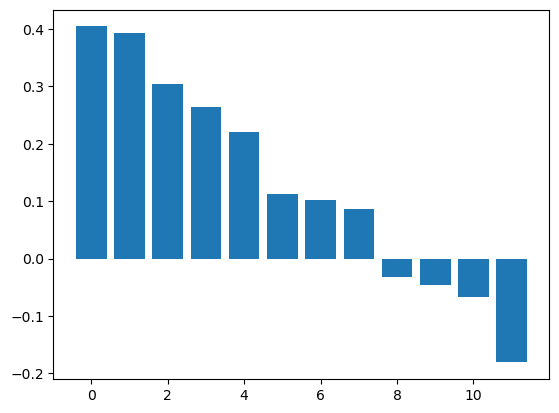

In [18]:
# get importance for logistic regression
importance = model.coef_[0]
indices = np.argsort(importance)[::-1]
for i,v in enumerate(zip(X.columns[indices], importance[indices])):
    print('Feature: {}  Score: {}' .format(i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance[indices])
plt.show()

## rough

In [19]:
df['y_reg'].describe(percentiles=[i/100 for i in range(0,100,10)])

count    145531.000000
mean          2.516570
std           8.101248
min           0.000000
0%            0.000000
10%           0.000000
20%           0.000000
30%           0.000000
40%           0.000000
50%           1.000000
60%           1.000000
70%           2.000000
80%           3.000000
90%           6.000000
max         662.000000
Name: y_reg, dtype: float64

<AxesSubplot:xlabel='y_reg', ylabel='Count'>

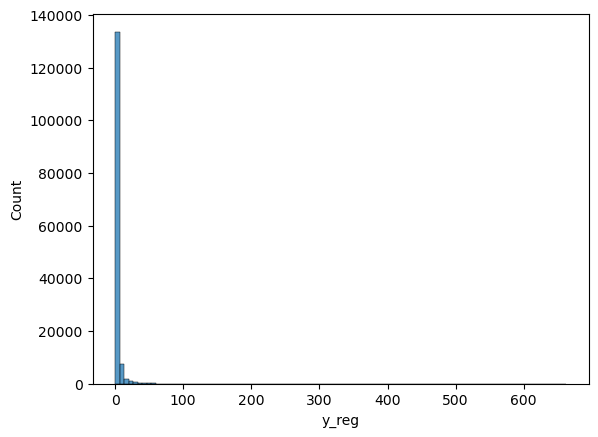

In [20]:
temp = df[df['y_reg']<50000].reset_index()
sns.histplot(data=temp, x="y_reg", bins=100)

In [21]:
works[works['cited_by_count']>200]

,doi,title,type,publication_date,host_venue,open_access_is_oa,open_access_oa_status,authorships,page_count,cited_by_count,concepts,referenced_works,abstract,counts_by_year
id,,,,,,,,,,,,,,
W2555618208,https://doi.org/10.1109/cvpr.2017.691,Multi-view 3D Object Detection Network for Aut...,proceedings-article,2017-07-21,V4306417987,True,green,"[[A2119051707, [I99065089]], [A2151001937, [I9...",-1,1409,"[[C131979681, 0.86888766], [C41008148, 0.77201...","[W7746136, W1536680647, W1914646313, W19466097...",This paper aims at high-accuracy 3D object det...,"[(2017, 13), (2018, 109), (2019, 308), (2020, ..."
W2557641257,https://doi.org/10.1109/cvpr.2017.733,ECO: Efficient Convolution Operators for Tracking,proceedings-article,2017-07-21,V4306417987,True,green,"[[A260882311, [I102134673]], [A2557978175, [I1...",-1,1322,"[[C63479239, 0.8030945], [C68339613, 0.7788200...","[W1857884451, W1892578678, W1904671147, W19157...","In recent years, Discriminative Correlation Fi...","[(2017, 9), (2018, 133), (2019, 303), (2020, 3..."
W2963709863,https://doi.org/10.1109/cvpr.2017.241,Learning from Simulated and Unsupervised Image...,proceedings-article,2017-07-21,V4306417987,True,green,"[[A2183241032, [I1311269955]], [A2798413642, [...",-1,1277,"[[C41008148, 0.8212265], [C2779803651, 0.78661...","[W1922126009, W1950149599, W1995694455, W20012...","With recent progress in graphics, it has becom...","[(2017, 55), (2018, 251), (2019, 356), (2020, ..."
W2594519801,https://doi.org/10.1109/cvpr.2017.261,ScanNet: Richly-Annotated 3D Reconstructions o...,proceedings-article,2017-07-21,V4306417987,True,green,"[[A2158018495, [I97018004]], [A2111957820, [I2...",-1,1116,"[[C41008148, 0.8516614], [C82990744, 0.6491697...","[W218762409, W1509835260, W1565402342, W159436...",A key requirement for leveraging supervised de...,"[(2017, 12), (2018, 76), (2019, 226), (2020, 3..."
W2561715562,https://doi.org/10.1109/cvpr.2017.215,CLEVR: A Diagnostic Dataset for Compositional ...,proceedings-article,2017-07-01,V4306417987,True,green,"[[A2345205178, [I97018004]], [A1988254826, [I2...",-1,1085,"[[C41008148, 0.7745689], [C130440534, 0.751482...","[W1933349210, W1983927101, W1996418862, W20646...",When building artificial intelligence systems ...,"[(2017, 38), (2018, 146), (2019, 232), (2020, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W2964297864,https://doi.org/10.1109/iccv.2017.137,Adversarial PoseNet: A Structure-Aware Convolu...,proceedings-article,2017-04-30,V4306419272,True,green,"[[A2672142776, [I36399199]], [A2139473605, [I5...",-1,205,"[[C2779803651, 0.8591261], [C177769412, 0.8495...","[W1936750108, W1994529670, W2013640163, W20318...","For human pose estimation in monocular images,...","[(2017, 2), (2018, 36), (2019, 65), (2020, 48)..."
W2555428947,https://doi.org/10.18653/v1/d17-1039,Unsupervised Pretraining for Sequence to Seque...,proceedings-article,2017-09-01,V4306418267,True,hybrid,"[[A2953580041, [I157725225]], [A2551433269, [I...",-1,204,"[[C170858558, 0.8504702], [C203005215, 0.82808...","[W23305027, W1544827683, W1591801644, W1753482...",This work presents a general unsupervised lear...,"[(2017, 11), (2018, 40), (2019, 78), (2020, 40..."
W2963414781,https://doi.org/10.1109/asru.2017.8268935,"Exploring architectures, data and units for st...",proceedings-article,2017-12-01,V4306498158,True,green,"[[A2120260697, [I1291425158]], [A2639960128, [...",-1,204,"[[C41008148, 0.85740614], [C147168706, 0.82748...","[W1531333757, W1593247906, W2064675550, W21271...",We investigate training end-to-end speech reco...,"[(2017, 4), (2018, 27), (2019, 46), (2020, 62)..."


<AxesSubplot:xlabel='cited_by_count', ylabel='Count'>

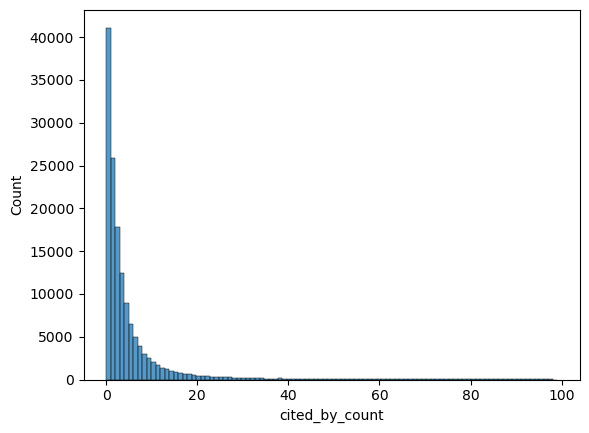

In [22]:
temp = works[works['cited_by_count']<100].reset_index()
sns.histplot(data=temp, x="cited_by_count", bins=100)

<AxesSubplot:xlabel='cited_by_count', ylabel='Count'>

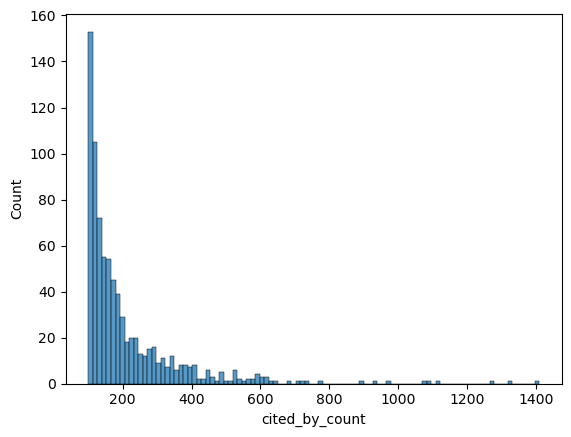

In [23]:
temp = works[works['cited_by_count']>100].reset_index()
sns.histplot(data=temp, x="cited_by_count", bins=100)